# #Fields from Snyder

In [2]:
%load_ext autoreload
%autoreload 2
from fieldgenesis import *
import wavesight as ws
from matplotlib import pyplot as plt
import cmasher as cmr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fiber_spec = {'nCladding': 1.5,
'nCore': 2.5,
'coreRadius': 1.0,
'λFree': 0.532,
}
fiber_sol = ws.multisolver(fiber_spec, verbose=True,solve_modes='all')

Approx number of complex HE modes:  127
Approx number of TE modes:  11
Approx number of TM modes:  11
Approx number of total modes:  278
Approx Max n for HE modes:  15
Calculating TM(0,n) propagation constants ...
Calculating TE(0,n) propagation constants ...
Calculating HE(m,n) propagation constants ...
m=20
HE modes = 266
TE modes = 7
TM modes = 7
TOTAL modes = 280
FROM_Vnum = 278


In [4]:
a = fiber_spec['coreRadius']
kFree = fiber_spec['kFree']
λFree = 2*np.pi/kFree
m = 3
kz = fiber_sol['HEkz'][m][1]
nCladding = fiber_spec['nCladding']
nCore = fiber_spec['nCore']
Efuncs, Hfuncs = fieldGenerator(a=a, kFree=kFree, kz=kz, m=m, nCladding=nCladding, nCore=nCore, fieldType='HE')
(ECoreρ, ECoreϕ, ECorez, ECladdingρ, ECladdingϕ, ECladdingz) = Efuncs
(HCoreρ, HCoreϕ, HCorez, HCladdingρ, HCladdingϕ, HCladdingz) = Hfuncs
def Efun(a):
    def fun(ρ):
        if ρ<a:
            return ECoreρ(ρ), ECoreϕ(ρ), ECorez(ρ)
        else:
            return ECladdingρ(ρ), ECladdingϕ(ρ), ECladdingz(ρ)
    return fun
def Hfun(a):
    def fun(ρ):
        if ρ<a:
            return HCoreρ(ρ), HCoreϕ(ρ), HCorez(ρ)
        else:
            return HCladdingρ(ρ), HCladdingϕ(ρ), HCladdingz(ρ)
    return fun

In [5]:
ptitle = f'λFree = {λFree:.2f} μm, a = {a:.2f} μm, m = {m}'

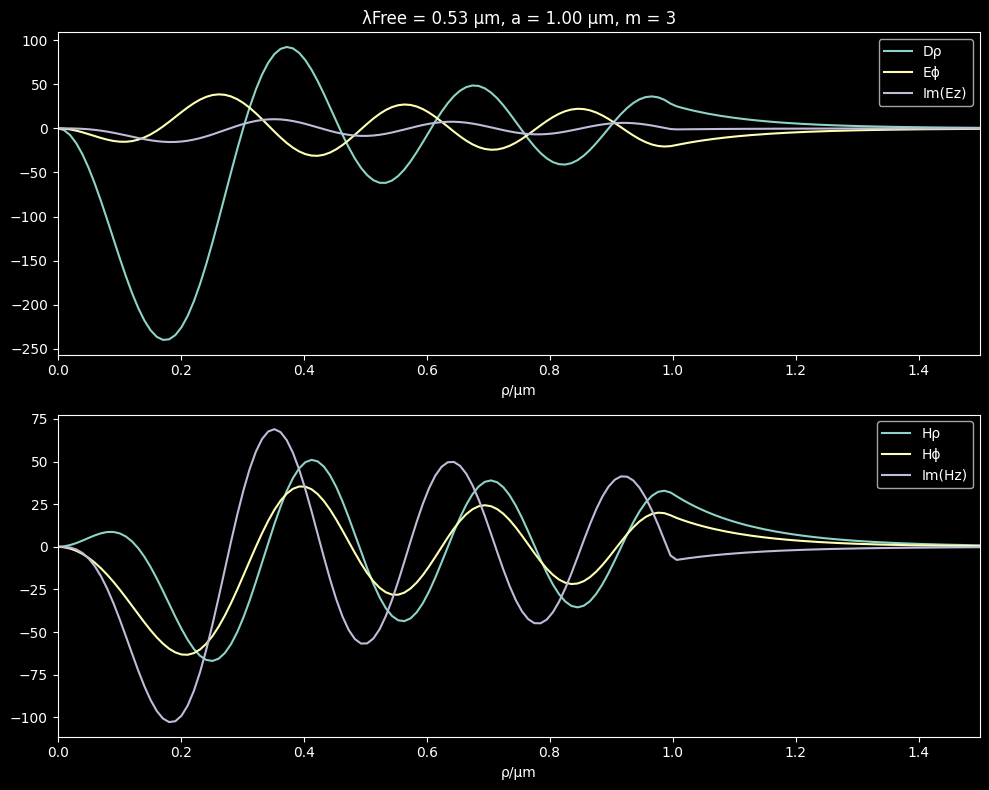

In [6]:
N = 150
dρ = a/N
ρrange = np.linspace(0,1.5*a,N)
electricFun = Efun(a)
electricFun = np.vectorize(electricFun)
magneticFun = Hfun(a)
magneticFun = np.vectorize(magneticFun)
Evals = electricFun(ρrange)
Hvals = magneticFun(ρrange)
refIndex = np.zeros(N)
refIndex[ρrange<a] = nCore
refIndex[ρrange>=a] = nCladding
permittivity = refIndex**2
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
axes[0].plot(ρrange,Evals[0]*permittivity,label='Dρ')
axes[0].plot(ρrange,Evals[1],label='Eϕ')
axes[0].plot(ρrange,np.imag(Evals[2]),label='Im(Ez)')
axes[1].plot(ρrange,Hvals[0],label='Hρ')
axes[1].plot(ρrange,Hvals[1],label='Hϕ')
axes[1].plot(ρrange,np.imag(Hvals[2]),label='Im(Hz)')
for ax in axes:
    ax.set_xlim(0,1.5*a)
    ax.set_xlabel('ρ/μm')
    ax.legend()
axes[0].set_title(ptitle)
plt.tight_layout()
plt.show()

In [6]:
xrange = np.linspace(-1.5 * a, 1.5 * a, N)
yrange = np.linspace(-1.5 * a, 1.5 * a, N)
xmesh, ymesh = np.meshgrid(xrange, yrange)
ρmesh = np.sqrt(xmesh ** 2 + ymesh ** 2)
ϕmesh = np.arctan2(ymesh, xmesh)
cosMesh = np.cos(m*ϕmesh)
sinMesh = np.sin(m*ϕmesh)

In [7]:
electricMesh = electricFun(ρmesh)
magneticMesh = magneticFun(ρmesh)
electricMesh = np.array(electricMesh)
magneticMesh = np.array(magneticMesh)
electricMeshEven = np.copy(electricMesh)
electricMeshOdd =  np.copy(electricMesh)
magneticMeshEven = np.copy(magneticMesh)
magneticMeshOdd = np.copy(magneticMesh)

if m > 0:
    electricMeshEven[0] = electricMeshEven[0]*cosMesh
    electricMeshEven[1] = -electricMeshEven[1]*sinMesh
    electricMeshEven[2] = electricMeshEven[2]*cosMesh
    electricMeshOdd[0] = electricMeshOdd[0]*sinMesh
    electricMeshOdd[1] = electricMeshOdd[1]*cosMesh
    electricMeshOdd[2] = electricMeshOdd[2]*sinMesh

    magneticMeshEven[0] = magneticMeshEven[0]*cosMesh
    magneticMeshEven[1] = -magneticMeshEven[1]*sinMesh
    magneticMeshEven[2] = magneticMeshEven[2]*cosMesh
    magneticMeshOdd[0] = magneticMeshOdd[0]*sinMesh
    magneticMeshOdd[1] = magneticMeshOdd[1]*cosMesh
    magneticMeshOdd[2] = magneticMeshOdd[2]*sinMesh

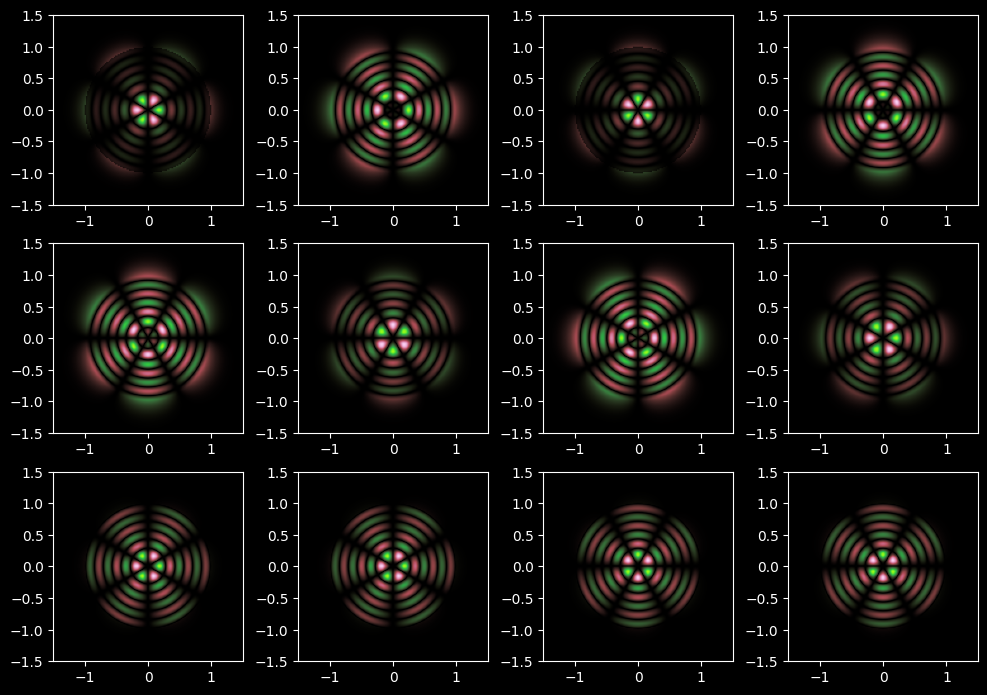

In [8]:
extent = [-1.5*a, 1.5*a, -1.5*a, 1.5*a]
fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(10,7))
for idx in range(3):
    if idx == 0 or idx == 1:
        imFun = np.real
    else:
        imFun = np.imag
    pData = imFun(electricMeshEven[idx])
    ranger = np.max(np.abs(pData))
    axes[idx,0].imshow(pData, vmin=-ranger, vmax=ranger, extent=extent, cmap=cmr.watermelon)
    pData = imFun(magneticMeshEven[idx])
    ranger = np.max(np.abs(pData))
    axes[idx,1].imshow(pData, vmin=-ranger, vmax=ranger, extent=extent, cmap=cmr.watermelon)
    pData = imFun(electricMeshOdd[idx])
    ranger = np.max(np.abs(pData))
    axes[idx,2].imshow(pData, vmin=-ranger, vmax=ranger, extent=extent, cmap=cmr.watermelon)
    pData = imFun(magneticMeshOdd[idx])
    ranger = np.max(np.abs(pData))
    axes[idx,3].imshow(pData, vmin=-ranger, vmax=ranger, extent=extent, cmap=cmr.watermelon)
plt.tight_layout()
plt.show()